Things I tried that didn't improve the score:-
- Use combination of cos and sin to feature engineer
- Use Labelencoder to encode categories
- Use Kmeans to create a new feature containing clusters
- Create aggregate features based on new created id with the help of age, profession, gender 
- Create aggregate features based on new created id with the help of category_id, video_id
- Use custom bagging
- Use combination of stacked regressors
- Use three LSTM along with dropout and dense 



This is the final solution that gave me the highest score on leaderboard

#Loading data and EDA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import scipy

In [ ]:
train = pd.read_csv('train_0OECtn8.csv')

In [ ]:
train

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13
...,...,...,...,...,...,...,...,...,...,...
89192,89193,23996,15,32,25,Male,Other,340,662,3.91
89193,89194,20466,20,47,31,Male,Other,240,892,3.56
89194,89195,13655,16,97,25,Male,Student,270,462,4.23
89195,89196,24840,9,18,35,Male,Working Professional,230,819,3.77


In [ ]:
train.describe()

,row_id,user_id,category_id,video_id,age,followers,views,engagement_score
count,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000
mean,44599.000000,13881.909806,18.323733,77.715383,24.848616,252.460172,502.980268,3.487797
std,25749.100318,8005.582771,11.675154,48.469656,8.955535,46.094468,268.569482,0.863498
min,1.000000,1.000000,1.000000,1.000000,10.000000,160.000000,30.000000,0.000000
25%,22300.000000,6945.000000,8.000000,34.000000,18.000000,230.000000,229.000000,2.900000
50%,44599.000000,13892.000000,16.000000,76.000000,23.000000,240.000000,467.000000,3.710000
75%,66898.000000,20819.000000,26.000000,120.000000,32.000000,280.000000,714.000000,4.150000
max,89197.000000,27734.000000,47.000000,175.000000,68.000000,360.000000,1000.000000,5.000000


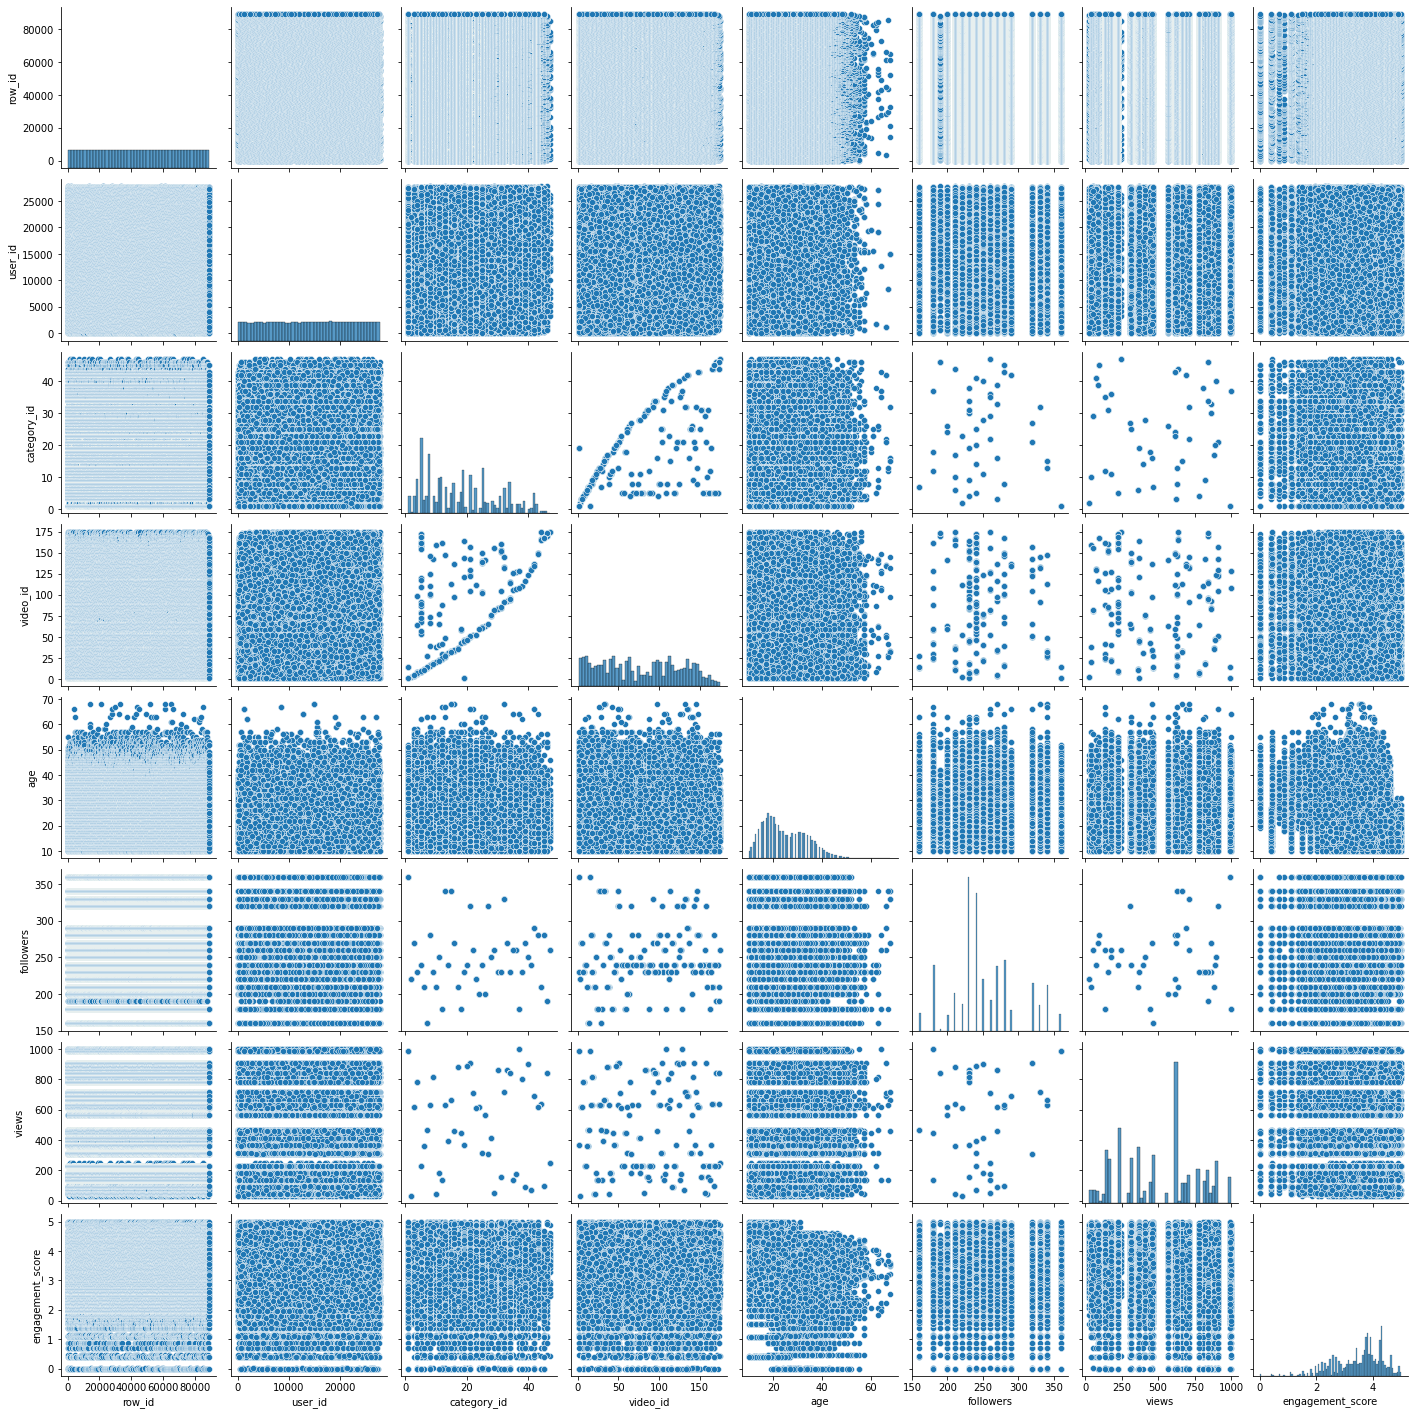

In [ ]:
sns.pairplot(train)

There's some correlation between views and followers and video_id and category_id

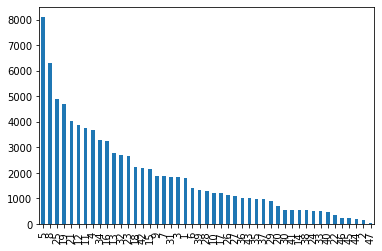

In [ ]:
train['category_id'].value_counts().plot.bar()

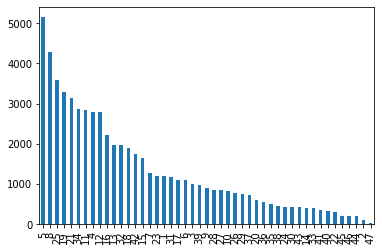

In [ ]:
train.loc[train['engagement_score'] < 4]['category_id'].value_counts().plot.bar()

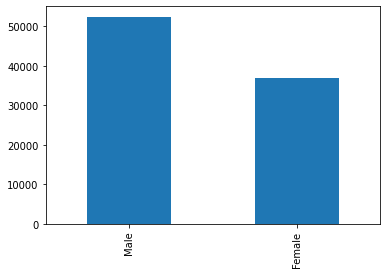

In [ ]:
train['gender'].value_counts().plot.bar()

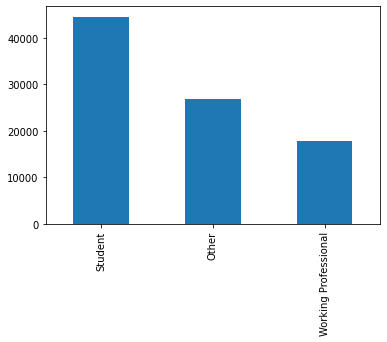

In [ ]:
train['profession'].value_counts().plot.bar()

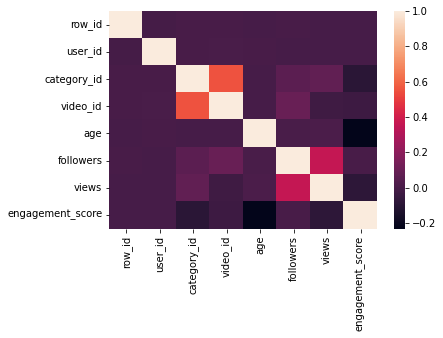

In [ ]:
sns.heatmap(train.corr())

Not much correlation between features.

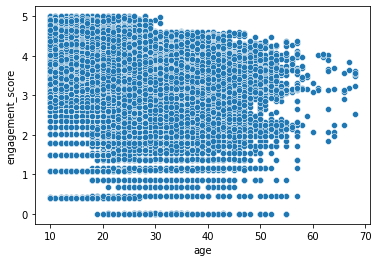

In [ ]:
sns.scatterplot(x='age', y='engagement_score',data=train)

Above 30 years there are no 5 engagement scores.

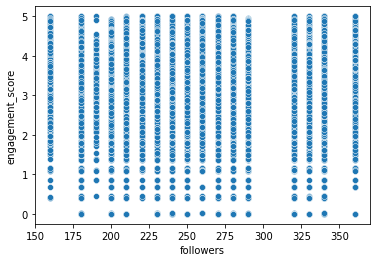

In [ ]:
sns.scatterplot(x='followers', y='engagement_score',data=train)

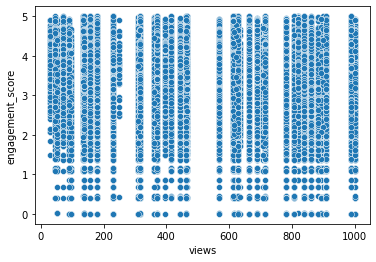

In [ ]:
sns.scatterplot(x='views', y='engagement_score',data=train)

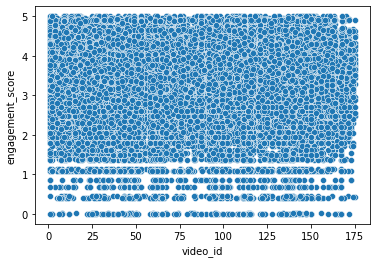

In [ ]:
sns.scatterplot(x='video_id', y='engagement_score',data=train)

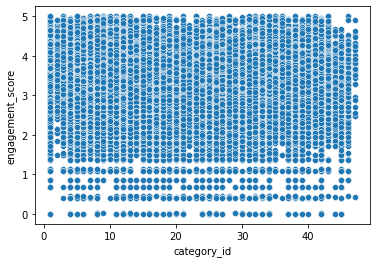

In [ ]:
sns.scatterplot(x='category_id', y='engagement_score',data=train)

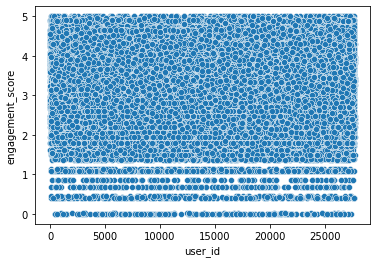

In [ ]:
sns.scatterplot(x='user_id', y='engagement_score',data=train)

#Preprocessing

In [ ]:
train['binary_age'] = train.age.apply(lambda x: 0 if x >= 30 else 1 ) #0 if age is more than 30 and 1 if below 30

In [ ]:
train['log_views'] = train.views.apply(lambda x: np.log(x) ) #log of feature views

#One hot encoding

In [ ]:
le = OneHotEncoder(handle_unknown='ignore') 
le.fit(train['gender'].values.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [ ]:
train_gender = le.transform(train['gender'].values.reshape(-1,1))

In [ ]:
le2 = OneHotEncoder(handle_unknown='ignore')
le2.fit(train['profession'].values.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [ ]:
train_profession = le2.transform(train['profession'].values.reshape(-1,1))

In [ ]:
le3 = OneHotEncoder(handle_unknown='ignore')
le3.fit(train['category_id'].values.reshape(-1,1))

OneHotEncoder(handle_unknown='ignore')

In [ ]:
train_cat = le3.transform(train['category_id'].values.reshape(-1,1))

In [ ]:
train.drop(['profession', 'gender','row_id','category_id'], axis=1, inplace=True)

#Standard Scaling

In [ ]:
sc = StandardScaler()

In [ ]:
sc.fit(train['age'].values.reshape(-1,1))

StandardScaler()

In [ ]:
age_sc = sc.transform(train['age'].values.reshape(-1,1))

In [ ]:
sc2 = StandardScaler()
views_sc = sc2.fit_transform(train['views'].values.reshape(-1,1))

In [ ]:
sc3 = StandardScaler()
followers_sc = sc3.fit_transform(train['followers'].values.reshape(-1,1))

In [ ]:
sc4 = StandardScaler()
video_sc = sc4.fit_transform(train['video_id'].values.reshape(-1,1))

In [ ]:
sc5 = StandardScaler()
user_sc = sc5.fit_transform(train['user_id'].values.reshape(-1,1))

#hstack and train test split

In [ ]:
x = train.drop(["engagement_score",'followers','views','age','user_id','video_id'], axis=1)
y = train['engagement_score']

In [ ]:
x = scipy.sparse.hstack((x.values,train_profession,train_gender, train_cat, age_sc, views_sc, followers_sc,video_sc, user_sc)).tocsr()

In [ ]:
x.shape

(89197, 59)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y.values, test_size=0.2)

#XGBOOST

In [ ]:
clfy2 = xgboost.XGBRegressor(
            n_estimators=10000,
            max_depth=16,
            learning_rate=0.04,
            colsample_bytree=0.2,
            objective='reg:squarederror'
        )                                      #these parameters are result of Randomsearchcv

In [ ]:
clfy2.fit(train_x, train_y)

XGBRegressor(colsample_bytree=0.2, learning_rate=0.04, max_depth=16,
             n_estimators=10000, objective='reg:squarederror')

In [ ]:
predict = clfy2.predict(test_x)

In [ ]:
r2_score(test_y, predict)    #checking the r2 score

0.43196414223468094

#Prediction on the test data

In [ ]:
test = pd.read_csv('test_1zqHu22.csv')

In [ ]:
row_id = test['row_id']

In [ ]:
test['binary_age'] = test.age.apply(lambda x: 0 if x >= 30 else 1 )

In [ ]:
test['log_views'] = test.views.apply(lambda x: np.log(x) )

In [ ]:
test_gender = le.transform(test['gender'].values.reshape(-1,1))

In [ ]:
test_profession = le2.transform(test['profession'].values.reshape(-1,1))

In [ ]:
test_cat = le3.transform(test['category_id'].values.reshape(-1,1))

In [ ]:
age_te = sc.transform(test['age'].values.reshape(-1,1))

In [ ]:
views_te = sc2.transform(test['views'].values.reshape(-1,1))

In [ ]:
followers_te = sc3.transform(test['followers'].values.reshape(-1,1))

In [ ]:
video_te = sc4.transform(test['video_id'].values.reshape(-1,1))

In [ ]:
user_te = sc5.transform(test['user_id'].values.reshape(-1,1))

In [ ]:
test.drop(['profession', 'gender','row_id','followers','views','age','category_id','user_id','video_id'], axis=1, inplace=True)

In [ ]:
x_t = scipy.sparse.hstack((test.values,test_profession,test_gender, test_cat,age_te,views_te,followers_te,video_te,user_te)).tocsr()

In [ ]:
prediction = clfy2.predict(x_t)

In [ ]:
submit = pd.DataFrame({'row_id' : row_id, 'engagement_score': prediction})

In [ ]:
submit.head(5)

,row_id,engagement_score
0,89198,4.127026
1,89199,3.673163
2,89200,2.885010
3,89201,3.156082
4,89202,1.745639


In [ ]:
submit.to_csv('submission19.csv', index=False)